# Interaction potential

What is the interaction potential between two particles? Does it reproduces the results of Osterman (PRL 2007)? 

What does the potential look like if particles have parallel moments?

In [3]:
import lammps2d as lmp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import trackpy as tp

%matplotlib inline
%reload_ext autoreload
%autoreload 2

I first define a new simulation with a standard parameter set. 

In [4]:
temp = 300 # K
Kb = 4/300 # pN nm / K
diffusion = 0.1e6 #nm^2/s
drag = Kb*temp/diffusion #pN/(nm/s)

sgm = 2.8 #um
B = 3 #mT
chi = 0.5 #n.a.

initial_positions = np.array([[-1.41,0,0.1],[1.41,0,-0.1]])

sim = lmp.sim(initial_positions,
              magnitude = B,
              radius = sgm/2,
              drag = drag,
              frequency=1,
              susceptibility = chi,
              angle=0,
              lj_parameters=[1,1/(2**(1/6))],
              lj_cutoff = 1,
              framerate=1e1,
              timestep=1e-4,
              total_time = 10,
              walls = [-10/2,10/2],
              temperature = 1)

## Generate Interaction Series 

I defined a new method for the simulation class, designed to obtain a plot of the interaction potential of a pair of particles

In [7]:
help(sim.generate_interaction_series)

Help on method generate_interaction_series in module lammps2d.simulation:

generate_interaction_series(start, n_points, end=[0, 0, 0]) method of lammps2d.simulation.sim instance
    This method generates a lammps script with no thermostat, 
    which simply moves a particle at a constant velocity through the x axis
    and dumps the force calculated by lammps.
    
    The parameters are, 
    * start (3 number array) a vector of the starting point,
    * n_points = number of points
    * end = [0,0,0] a vector of the end point.



<img src=GenerateInteractionSeries.png>

This methord creates two particles, one of them in the origin as shown in the previous figure. The other particle is moved in a straight line of $N_p$ points between a starting point and an end point in $3D$ space. For each point, LAMMPS prints both particles position, and the force *felt* by each particle due to the other particle. 

In [9]:
trj = sim.generate_interaction_series([10,0,0],1000,[0,0,0])
trj.head()

lmp_mingw64.exe -in test.lmpfieldin


fx   fy   fz        mu  mux  muy       muz  type      x    y  \
frame id                                                                        
0.0   1.0  0.000000  0.0  0.0  0.000046  0.0  0.0  0.000046   1.0  10.00  0.0   
      2.0  0.000000  0.0  0.0  0.000046  0.0  0.0  0.000046   1.0   0.00  0.0   
1.0   1.0  0.000006  0.0  0.0  0.000046  0.0  0.0  0.000046   1.0   9.99  0.0   
      2.0 -0.000006  0.0  0.0  0.000046  0.0  0.0  0.000046   1.0   0.00  0.0   
2.0   1.0  0.000006  0.0  0.0  0.000046  0.0  0.0  0.000046   1.0   9.98  0.0   

             z  
frame id        
0.0   1.0  0.0  
      2.0  0.0  
1.0   1.0  0.0  
      2.0  0.0  
2.0   1.0  0.0

Once I obtained this, I integrate the force acting on the moving particle, to obtain the potential:
$$ F = -\nabla U$$
$$ U(\vec{r}) = -\int_{\infty}^\vec{r} F.\mathrm{d}\vec{s}$$

In [22]:
def integrate(f,x):
    f = f.values
    x = x.values
    f01 = (f[1:]+f[:-1])/2
    dx = x[1:]-x[:-1]
    return np.cumsum(f01*dx)

def potential(F,r):
    U = -(integrate(F.fx,r.x) + integrate(F.fy,r.y) + integrate(F.fz,r.z))
    r = r.values
    r = (r[1:,:]+r[:-1,:])/2
    return U, r

## Interaction Potentials for Constant $z$

I now run the program for several trajectories, where each trajectory corresponds to a separation height, and therefore it starts and ends at the same vertical position. The value of $z$ corresponds to the height minus the particle diameter. 

<img src=Dobnikar_Geometry.png width=250px>

In [23]:
Z = np.linspace(0,2.5,5)
N = 1000
U = np.empty([N,np.size(Z)])
r = np.empty([N,np.size(Z)])
rt = np.empty([N,np.size(Z)])

for i,z in enumerate(Z):
    trj = sim.generate_interaction_series([10,0,z],1000,[0,0,z])
    idx = pd.IndexSlice
    U[:,i], rvec = potential(trj.loc[idx[:,1],('fx','fy','fz')],trj.loc[idx[:,1],('x','y','z')])
    r[:,i] = np.sqrt(rvec[:,0]**2 + rvec[:,1]**2 + rvec[:,2]**2)
    rt[:,i] = np.sqrt(rvec[:,0]**2 + rvec[:,1]**2)

lmp_mingw64.exe -in test.lmpfieldin
lmp_mingw64.exe -in test.lmpfieldin
lmp_mingw64.exe -in test.lmpfieldin
lmp_mingw64.exe -in test.lmpfieldin
lmp_mingw64.exe -in test.lmpfieldin


To get the potential in the same units as Dobnikar we must define (from Osterman 2007):
$$ K = \frac{\pi \sigma^6 \chi^2 B^2}{144\mu_0}$$

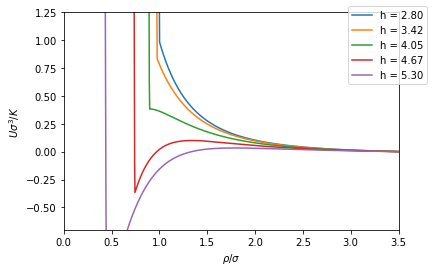

In [30]:
K = (np.pi * (sgm**6) * chi**2 * (B*1e6)**2) / (144 * np.pi*4e14)

plt.plot(rt/sgm,U*(sgm**3)/K)
plt.ylim([-0.7,1.25])
plt.xlim([0,3.5])
plt.legend(["h = %2.2f"%(i+sgm) for i in Z],bbox_to_anchor=(1.1, 1.05))
plt.xlabel("$\\rho / \sigma$")
plt.ylabel("$U\sigma^3/K$")

And from Dobnikar 2008: 

<img src=Dobnikar_Potential.png width=500px>

Note here that we are drawing the interaction potential as a function of the in plane distance $\rho$. That is why the different curves have different apparent particle diameter, shown in the figure as a sharp increase in potential. If we plot  the interaction potential as a function of the radius, we get that all curves collapse into the same diameter.

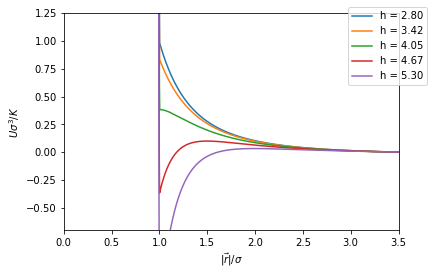

In [32]:
plt.plot(r/sgm,U*(sgm**3)/K)
plt.ylim([-0.7,1.25])
plt.xlim([0,3.5])
plt.legend(["h = %2.2f"%(i+sgm) for i in Z],bbox_to_anchor=(1.1, 1.05))
plt.xlabel("$|\\vec{r}| / \sigma$")
plt.ylabel("$U\sigma^3/K$")